## Load the Test Data

In [1]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,  # You can adjust the batch size
    shuffle=False
)

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s] 


## Load the Pretrained Model

In [4]:
import nbimporter
from model_building_paida import WideResNet  
model = WideResNet(depth=28, widen_factor=10, num_classes=10, drop_rate=0.0)

# Load the saved weights
model.load_state_dict(torch.load('wrn_model.pth'))
model.eval()  # Set the model to evaluation mode

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (shortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(

## Evaluate the Model

In [5]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize placeholders for predictions and targets
all_preds = []
all_targets = []

# Evaluate the model
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to the same device as the model (GPU if available)
        images, labels = images.to('cuda'), labels.to('cuda')
        model.to('cuda')
        
        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Append predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

## Generate Metrics and Visualizations

### Classification Report:

In [6]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=test_dataset.classes))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.76      0.94      0.84      1000
  automobile       0.96      0.86      0.91      1000
        bird       0.90      0.71      0.79      1000
         cat       0.78      0.69      0.73      1000
        deer       0.70      0.95      0.81      1000
         dog       0.80      0.79      0.79      1000
        frog       0.94      0.76      0.84      1000
       horse       0.91      0.86      0.89      1000
        ship       0.95      0.84      0.89      1000
       truck       0.79      0.97      0.87      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



### Confusion Matrix:

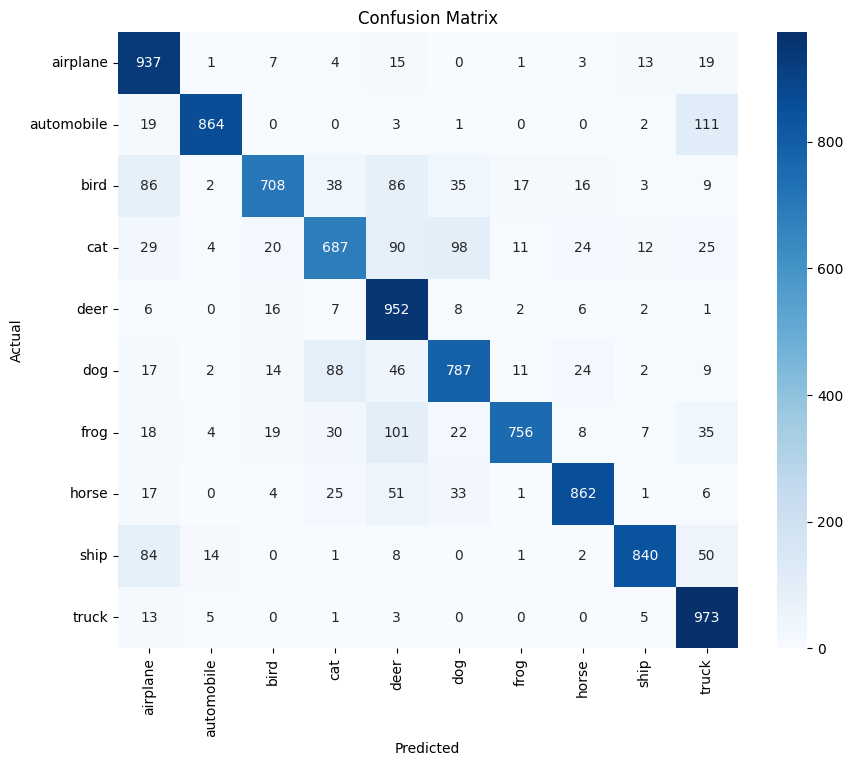

In [7]:
cm = confusion_matrix(all_targets, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Visualize Predictions
* Visualize a few test images with their predictions and actual labels:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7

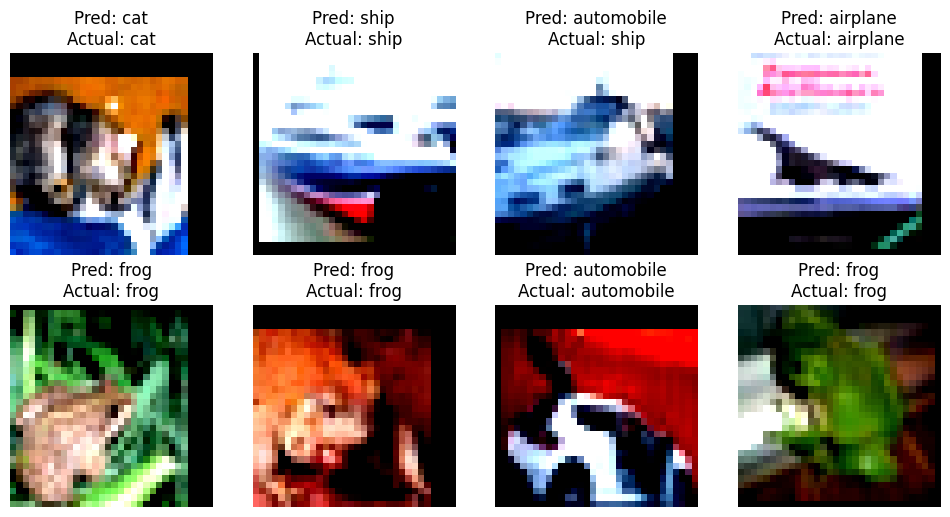

In [8]:
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get predictions for the batch
images, labels = images.to('cuda'), labels.to('cuda')
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot the images with predictions
plt.figure(figsize=(12, 6))
for idx in range(8):  # Display 8 images
    plt.subplot(2, 4, idx + 1)
    plt.imshow(images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize
    plt.title(f"Pred: {test_dataset.classes[preds[idx]]}\nActual: {test_dataset.classes[labels[idx]]}")
    plt.axis('off')
plt.show()

## Save Results

In [9]:
# Save classification report
with open('classification_report.txt', 'w') as f:
    f.write(classification_report(all_targets, all_preds, target_names=test_dataset.classes))

# Save confusion matrix
np.save('confusion_matrix.npy', cm)